In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import shapely
import os
import pickle
import numpy as np

# on climada_petals branch feature/networks until merged into develop!!
from climada_petals.engine.networks.nw_preps import NetworkPreprocess, PowerlinePreprocess, RoadPreprocess
from climada_petals.engine.networks.nw_base import Network
from climada_petals.engine.networks.nw_calcs import Graph
from climada_petals.engine.networks import nw_utils as nwu
from climada_petals.entity.exposures.openstreetmap import osm_dataloader as osm
from climada_petals.util.constants import DICT_GEOFABRIK

from climada.util import coordinates as u_coords
from climada.hazard.base import Hazard

# general paths & constants
PATH_DATA = '/cluster/work/climate/evelynm/nw_inputs/'
PATH_DATA_OSM = PATH_DATA +'osm_countries/'
PATH_DATA_HVMV = PATH_DATA +'power/hvmv_global.shp'
PATH_DATA_PP = PATH_DATA +'power/global_power_plant_database.csv'
PATH_DATA_CT = PATH_DATA +'opencellid_global_1km_int.tif'
PATH_DATA_POP = PATH_DATA + 'worldpop/'
PATH_DEPS = PATH_DATA + 'dependencies/dependencies_default.csv'
PATH_SAVE = '/cluster/work/climate/evelynm/nw_outputs/'
PATH_EL_CONS_GLOBAL = PATH_DATA +'power/final_consumption_iea_global.csv'
PATH_ET = PATH_DATA +'power/electrification_targets.tif'
PATH_FRICTION = PATH_DATA + 'friction/202001_Global_Walking_Only_Friction_Surface_2019.tif'
PATH_TREES = PATH_DATA + 'Crowther_Nature_Files/...'

In [24]:
import sys
cntry = 'Mozambique'

# =============================================================================
# Load Infra Data
# =============================================================================

iso3 = u_coords.country_to_iso(cntry)

try:
    path_osm_cntry = PATH_DATA_OSM+DICT_GEOFABRIK[iso3][-1]+'-latest.osm.pbf'
except KeyError:
    path_osm_cntry = PATH_DATA_OSM+f'{cntry}'+'-latest.osm.pbf'
path_worldpop_cntry = PATH_DATA_POP + f'{iso3.lower()}_ppp_2020_1km_Aggregated_UNadj.tif'
path_el_consump_cntry = PATH_DATA + f'power/Electricity consumption per capita - {cntry}.csv'
path_elgen_cntry = PATH_DATA + f'power/Electricity generation by source - {cntry}.csv'
path_el_imp_exp_cntry = PATH_DATA + f'power/Electricity imports vs. exports - {cntry}.csv'
path_save_cntry = PATH_SAVE + f'{iso3}/'
if not os.path.isdir(path_save_cntry):
    os.mkdir(path_save_cntry)

In [25]:
# COUNTRY SHAPE    
__, cntry_shape = u_coords.get_admin1_info([cntry])
cntry_shape = shapely.ops.unary_union([shp for shp in cntry_shape[iso3]])

In [26]:
# OSM Query Object
try:
    osm.OSMRaw().get_data_geofabrik(iso3, file_format='pbf', save_path=PATH_DATA_OSM)
except KeyError:
    osm.OSMRaw().extract_from_shapes([cntry_shape], path_poly=PATH_DATA_OSM+f'{iso3}.poly', 
                                     path_extract=path_osm_cntry, path_parentfile=PATH_DATA_OSM+'planet-latest.osm.pbf',
                                     overwrite=False)
CntryFileQuery = osm.OSMFileQuery(path_osm_cntry)

In [27]:
# POWER LINES
gdf_powerlines = gpd.read_file(PATH_DATA_HVMV, mask=cntry_shape)
gdf_powerlines['osm_id'] = 'n/a'
gdf_powerlines['ci_type'] = 'n/a' #random, preprocessing needs another column
gdf_powerlines = gdf_powerlines[['osm_id', 'geometry', 'ci_type']]

# POWER PLANTS
# try WRI power plant database, then OSM
gdf_pp = nwu.PowerFunctionalData().load_pplants_wri(PATH_DATA_PP, iso3)    

extract lines: 100%|██████████| 305/305 [00:11<00:00, 25.87it/s]


"\n    if len(gdf_pp[gdf_pp.power=='plant'])>1:\n        gdf_pp = gdf_pp[gdf_pp.power=='plant']\n    else:\n        # last 'resort': take generators from OSM\n        gdf_pp = gdf_pp[gdf_pp.power=='generator']       \n    gdf_pp['geometry'] = gdf_pp.geometry.apply(lambda geom: geom.centroid)\n    gdf_pp = gdf_pp[['name', 'power', 'geometry']]   \n"

In [36]:
# SUBSTATIONS
gdf_power = CntryFileQuery.retrieve_cis('power')
gdf_power = gdf_power[[power_type in ['generator','plant','substation','switch', 'transformer'] 
               for power_type in gdf_power.power]]
gdf_power['geometry'] = gdf_power.apply(lambda row: row.geometry.convex_hull, axis=1)
gdf_power=gdf_power.reset_index(drop=True)

extract lines: 100%|██████████| 305/305 [00:11<00:00, 25.73it/s]


In [55]:
gdf_power.groupby('power').count()

,osm_id,voltage,utility,name,geometry
power,,,,,
generator,54,0,0,1,54
plant,1,0,0,10,11
substation,75,48,0,20,75
switch,2,0,0,0,2
transformer,68,0,0,2,68


In [ ]:
gdf_power.groupby('power').count()

In [ ]:
# PEOPLE
nwu.get_worldpop_data(iso3, PATH_DATA_POP)
gdf_people = nwu.load_resampled_raster(path_worldpop_cntry, 1)
pop_thresh = nwu.get_pop_cutoff(gdf_people, 0.1)
gdf_people = gdf_people[gdf_people.counts>=pop_thresh].reset_index(drop=True)

In [ ]:
# assign electricity consumption & production
gdf_people['electrified'] = nwu.PowerFunctionalData().assign_el_targets(
    gdf_people, iso3, cntry_shape, PATH_ET)
gdf_people, gdf_pp = nwu.PowerFunctionalData().assign_el_prod_consump(
    gdf_people, gdf_pp, iso3, PATH_EL_CONS_GLOBAL)

In [6]:
# HEALTH FACILITIES
# from osm
""" 
gdf_health = CntryFileQuery.retrieve_cis('healthcare') 
gdf_health['geometry'] = gdf_health.geometry.apply(lambda geom: geom.centroid)
gdf_health = gdf_health[['name', 'geometry']]
gdf_health = gdf_health[gdf_health.geometry.within(cntry_shape)]
"""

# pre-processed from Zélie:
path_health = '/cluster/work/climate/evelynm/nw_outputs/MOZ/locations_preprocessed.csv'
gdf_health = pd.read_csv(path_health)
gdf_health = gpd.GeoDataFrame(gdf_health, crs='EPSG:4326')
gdf_health['geometry'] = gdf_health.apply(lambda row: shapely.wkt.loads(row.geometry), axis=1)
gdf_health = gdf_health.iloc[:, :-5]

<AxesSubplot:>

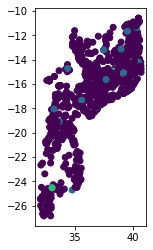

In [20]:
gdf_health.plot('Level')

In [ ]:
# EDUC. FACILITIES
# from osm
gdf_educ = CntryFileQuery.retrieve_cis('education')
gdf_educ['geometry'] = gdf_educ.geometry.apply(lambda geom: geom.centroid)
gdf_educ = gdf_educ[['name', 'geometry']]
gdf_educ = gdf_educ[gdf_educ.geometry.within(cntry_shape)]

# TELECOM
# cells from rasterized opencellID (via WB)
path_ct_cntry = path_save_cntry+'celltowers.tif'
if not Path(path_ct_cntry).is_file():
    if cntry_shape.type=='Polygon':
        geo_mask = [cntry_shape]
    else:
        geo_mask = [mp for mp in cntry_shape]
    meta_ct, arr_ct = u_coords.read_raster(PATH_DATA_CT, src_crs={'epsg':'4326'},
                                           geometry=geo_mask)
    u_coords.write_raster(path_ct_cntry, arr_ct, meta_ct)
gdf_cells = nwu.load_resampled_raster(path_ct_cntry, 1/5)

# ROADS
# from osm; by default, take all types of roads
gdf_roads = CntryFileQuery.retrieve_cis('road') # for large countries: take main_road only and uncomment later ones
frac_unclass = gdf_roads.groupby('highway').size()['unclassified']/len(gdf_roads)

if frac_unclass < 0.2:
    # if unclassified road fraction is quite small, take only main roads
    gdf_roads = gdf_roads[(gdf_roads.highway != 'residential') & 
                          (gdf_roads.highway != 'unclassified')]

gdf_roads = gdf_roads[gdf_roads.geometry.type=='LineString']
gdf_roads = gdf_roads[['osm_id','highway', 'geometry']]
gdf_roads = gdf_roads[gdf_roads.within(cntry_shape)]


In [ ]:
# =============================================================================
# # Graphs
# =============================================================================

# POWER LINES
gdf_power_edges, gdf_power_nodes = PowerlinePreprocess().preprocess(
    gdf_edges=gdf_powerlines)
power_network = Network(gdf_power_edges, gdf_power_nodes)
power_graph = Graph(power_network, directed=False)

iter_count = 0
while (len(power_graph.graph.clusters())>1) and (iter_count<8):
    iter_count+=1
    power_graph.link_clusters(dist_thresh=200000)
    
power_network = Network().from_graphs([power_graph.graph.as_directed()])
# power_graph.graph.clusters().summary(): 


In [ ]:
# PEOPLE
__, gdf_people_nodes = NetworkPreprocess('people').preprocess(
    gdf_nodes=gdf_people)
people_network = Network(nodes=gdf_people_nodes)

# POWER PLANTS
__, gdf_pp_nodes = NetworkPreprocess('power_plant').preprocess(
    gdf_nodes=gdf_pp)
pplant_network = Network(nodes=gpd.GeoDataFrame(gdf_pp_nodes))

# HEALTHCARE
__, gdf_health_nodes = NetworkPreprocess('health').preprocess(
    gdf_nodes=gdf_health)
health_network = Network(nodes=gdf_health_nodes)

# EDUC
__, gdf_educ_nodes = NetworkPreprocess('education').preprocess(
    gdf_nodes=gdf_educ)
educ_network = Network(nodes=gdf_educ_nodes)

In [ ]:
# ROAD
gdf_road_edges, gdf_road_nodes = RoadPreprocess().preprocess(
    gdf_edges=gdf_roads)
road_network = Network(gdf_road_edges, gdf_road_nodes)

endpoints: 100%|██████████| 954726/954726 [00:26<00:00, 35614.04it/s]


In [ ]:
# easy workaround for doubling edges
road_graph = Graph(road_network, directed=False)
iter_count = 0
while (len(road_graph.graph.clusters())>1) and (iter_count<5):
    iter_count+=1
    print(iter_count)
    road_graph.link_clusters(dist_thresh=30000)

road_network = Network().from_graphs([road_graph.graph.as_directed()])
#road_graph.graph.clusters().summary()
# save in between, because takes very long to create in case memory overflow
# road_network.nodes.to_feather(path_save_cntry+'road_nw_nodes')
# road_network.edges.to_feather(path_save_cntry+'road_nw_edges')

In [ ]:
# TELECOM
__, gdf_tele_nodes = NetworkPreprocess('celltower').preprocess(gdf_nodes=gdf_cells)
tele_network = Network(nodes=gdf_tele_nodes)

# MULTINET
cis_network = Network.from_nws([pplant_network, power_network,
                                people_network, health_network, educ_network,
                                road_network, tele_network])
cis_network.initialize_funcstates()

In [ ]:
# =============================================================================
# Interdependencies
# =============================================================================

# load default dependency table
df_dependencies = pd.read_csv(PATH_DEPS, sep=',', header=0)
df_dependencies.loc[np.isnan(df_dependencies.thresh_dist), 'thresh_dist'] = np.inf


In [ ]:
# refine dependency table
cond = ('electrified', True)
df_dependencies['conditions'] = None
df_dependencies['conditions'] = df_dependencies['conditions'].astype(object)
idx = np.where((df_dependencies.source=='power_line') & (
    df_dependencies.target=='people'))[0][0]
df_dependencies.at[idx, 'conditions'] = cond
df_dependencies = nwu.set_distance_threshs(df_dependencies, iso3, hrs_max=1)
if frac_unclass >= 0.2:
    # if all roads are taken, set a shorter dist thresh, else leave original main-road thresh
    df_dependencies.loc[(df_dependencies.source=='road') &
                        (df_dependencies.target=='people'), 'thresh_dist'] = 2000

In [ ]:
cis_graph = Graph(cis_network, directed=True)

In [ ]:
# create "missing physical structures" - needed for real world flows
cis_graph.link_vertices_closest_k(
    'power_line', 'power_plant', link_name='power_line', dist_thresh=np.inf, bidir=True, k=1)

In [ ]:
cis_graph.link_vertices_closest_k(
    'road', 'people',  link_name='road', 
    dist_thresh=df_dependencies.loc[(df_dependencies.source=='road') & 
                                    (df_dependencies.target=='people'),
                                    'thresh_dist'].values[0], bidir=True, k=1)

In [ ]:
cis_graph.link_vertices_closest_k(
    'road', 'health',  link_name='road', dist_thresh=np.inf, bidir=True, k=1)
cis_graph.link_vertices_closest_k(
    'road', 'education', link_name='road', dist_thresh=np.inf, bidir=True, k=1)

In [ ]:
# place dependencies
friction_surf = Hazard('FRIC').from_raster(
    PATH_FRICTION, geometry=[cntry_shape.convex_hull.buffer(0.1)])

for __, row in df_dependencies.iterrows():
    cis_graph.place_dependency(row.source, row.target, 
                               single_link=row.single_link,
                               access_cnstr=row.access_cnstr, 
                               dist_thresh=row.thresh_dist,
                               preselect=False,
                               friction_surf=friction_surf,
                               dur_thresh=60,
                               cond=row.conditions)
cis_network = cis_graph.return_network()

In [ ]:
# =============================================================================
# Base State
# =============================================================================

cis_network.initialize_funcstates()
for __, row in df_dependencies.iterrows():
    cis_network.initialize_capacity(row.source, row.target)
for __, row in df_dependencies[
        df_dependencies['type_I']=='enduser'].iterrows():
    cis_network.initialize_supply(row.source)

In [ ]:
nwu.get_graphstats(cis_graph)

In [ ]:
cis_graph = Graph(cis_network, directed=True)
cis_graph.cascade(df_dependencies, p_source='power_plant', p_sink='power_line', 
                  source_var='el_generation', demand_var='el_consumption',
                  preselect=False, initial=True, friction_surf=friction_surf, 
                  dur_thresh=60) # p_source = 'power_line' for countries wehre no pplants found
cis_network = cis_graph.return_network() #

In [ ]:
nwu.get_graphstats(cis_graph)

In [ ]:
cis_network.nodes.to_feather(path_save_cntry+'cis_nw_nodes')
cis_network.edges.to_feather(path_save_cntry+'cis_nw_edges')

In [ ]:
# save country-specific dependency-table.
df_dependencies.to_csv(path_save_cntry +f'dependency_table_{iso3}.csv')

In [ ]:
base_stats = nwu.number_noservices(cis_graph,
                         services=['power', 'healthcare', 'education', 
                                   'telecom', 'mobility'])

with open(path_save_cntry +f'base_stats_{iso3}.pkl', 'wb') as f:
    pickle.dump(base_stats, f) 

In [ ]:
base_stats

In [47]:
# compare with old stats
path_stats = path_save_cntry+f'old/base_stats_{iso3}.pkl'
with open(path_stats, 'rb') as old_stats_dict:
     old_stats_dict = pickle.load(old_stats_dict)
old_stats_dict

{'power': 1170.039707183838,
 'healthcare': 1170.039707183838,
 'education': 1170.039707183838,
 'telecom': 1170.039707183838,
 'mobility': 0.0}